In [1]:
from os import getenv
from dotenv import load_dotenv
from hub_downloader import Downloader

%reload_ext autoreload
%autoreload 1
%aimport hub_downloader

load_dotenv();

In [3]:
owner = 'pandas-dev'
repo = 'pandas'

github_token = getenv('GITHUB_OAUTH_TOKEN')
downloader = Downloader(owner, repo, github_token)
#downloader.delete_cache()

The maximum number of requests you are permitted to make per hour: 5000 

The number of requests remaining in the current rate limit window: 4998 



In [448]:
total_contributions, weekly_contributions = downloader.get_contributors_statistic()

In [449]:
total_contributions

,user,commits
0,xhochy,10
1,proost,10
2,Bharat123rox,10
3,funnycrab,11
4,dhimmel,11
...,...,...
95,TomAugspurger,663
96,jorisvandenbossche,694
97,jbrockmendel,1821
98,jreback,2758


In [450]:
weekly_contributions

,user,week_unix_ts,date,additions,deletions,commits
0,xhochy,1249171200,2009-08-02,0,0,0
1,xhochy,1249776000,2009-08-09,0,0,0
2,xhochy,1250380800,2009-08-16,0,0,0
3,xhochy,1250985600,2009-08-23,0,0,0
4,xhochy,1251590400,2009-08-30,0,0,0
...,...,...,...,...,...,...
56195,wesm,1586044800,2020-04-05,0,0,0
56196,wesm,1586649600,2020-04-12,0,0,0
56197,wesm,1587254400,2020-04-19,0,0,0
56198,wesm,1587859200,2020-04-26,0,0,0


In [10]:
stargazers = downloader.get_stargazers()
stargazers

,user,starred_at
0,sbusso,2010-08-24
1,auser,2010-08-24
2,pfig,2010-08-24
3,ludwig,2010-08-24
4,bryanveloso,2010-08-24
...,...,...
24954,mroeschke,2020-05-17
24955,miguelmarques1904,2020-05-18
24956,isseiyamamoto,2020-05-18
24957,debugger24,2020-05-18


In [457]:
issues = downloader.get_issues()
issues

,id,state,created_at
0,614078121,open,2020-05-07
1,614069454,open,2020-05-07
2,613954329,open,2020-05-07
3,613952453,open,2020-05-07
4,613896959,open,2020-05-07
...,...,...,...
3553,5787008,open,2012-07-23
3554,4863349,open,2012-06-01
3555,4647887,open,2012-05-18
3556,4485088,open,2012-05-09


In [458]:
code_frequency = downloader.get_code_frequency_statistic()
code_frequency

,week_unix_ts,additions,deletions,date
0,1249171200,21659,-4,2009-08-02
1,1249776000,0,0,2009-08-09
2,1250380800,0,0,2009-08-16
3,1250985600,0,0,2009-08-23
4,1251590400,1707,-819,2009-08-30
...,...,...,...,...
557,1586044800,6709,-3022,2020-04-05
558,1586649600,3052,-2322,2020-04-12
559,1587254400,3917,-2775,2020-04-19
560,1587859200,6274,-4252,2020-04-26


In [231]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import cumsum, datetime64, timedelta64, concatenate, full
from datetime import datetime
from pandas import to_datetime

class Visualiser():
    def __init__(self, owner, repo, useCache=True, figsize=(12, 7)):
        self.__figsize = figsize
        self.__owner = owner
        self.__repo = repo
                
        self.__downloader = Downloader(owner, repo, getenv('GITHUB_OAUTH_TOKEN'), useCache, False)
    
    def lines_over_time(self):
        '''Plots two graphs, one showing the total lines of code over time,
        the other the additions and deletions over time using line charts.'''
        
        code_frequency = self.__downloader.get_code_frequency_statistic()
        
        # parsing necessary data
        dates = code_frequency['date'].tolist()
        date_objects = [datetime.strptime(date, '%Y-%m-%d').date() for date in dates]
        
        additions = code_frequency['additions'].to_numpy()
        deletions = code_frequency['deletions'].to_numpy()
        total = additions + deletions
        cum_total = cumsum(total)

        # Total lines over time
        fig = plt.figure(figsize = self.__figsize) 
        
        plt.plot(date_objects, cum_total)
        plt.fill_between(date_objects, cum_total, alpha=0.2)
        
        plt.title('Total lines of code over time')
        plt.ylabel('Lines')
        plt.show()
        
        # Additions and deletions over time
        fig = plt.figure(figsize = self.__figsize)
        
        plt.plot(date_objects, additions, 'g-')
        plt.fill_between(date_objects, additions, alpha=0.2, color='g')
        plt.plot(date_objects, deletions, 'r-')
        plt.fill_between(date_objects, deletions, alpha=0.2, color='r')
        
        plt.title('Additions and deletions over time')
        plt.ylabel('Lines')
        plt.show()
        
    def commits_by_author(self, limit=12):
        '''Plots a pie chart showing the top contributors based on the commit count.'''
        
        total_contributions, _ = self.__downloader.get_contributors_statistic()
        
        if limit > len(total_contributions.index):
            limit = len(total_contributions.index)
            
        if limit < 2:
            limit = 10
        
        commits = total_contributions['commits'][-limit:].to_numpy()
        users = total_contributions['user'][-limit:].to_numpy()
        
        rest = sum(total_contributions['commits'][:-limit].to_numpy())
        
        commits = concatenate([[rest], commits])
        users = concatenate([['Others'], users])
                
        fig = plt.figure(figsize = self.__figsize) 
        
        plt.pie(commits, labels=users, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = full(len(commits), 0.05))
        
        centre_circle = plt.Circle((0, 0), 0.75, fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)
      
        plt.tight_layout()
        plt.title('Commits by authors')
        plt.show()
        
    def stargazer_history(self):
        stargazers = self.__downloader.get_stargazers()
                
        stargazers_by_day = stargazers.groupby('starred_at', as_index=False).count()
        stargazers_by_day.columns = ['date', 'stargazer_count']
        
        stargazers_by_week = stargazers_by_day
        stargazers_by_week['date'] = to_datetime(stargazers_by_week['date'])
        stargazers_by_week.index = stargazers_by_week['date'] 
        stargazers_by_week = stargazers_by_week.resample('M').sum()
        stargazers_by_week.reset_index(level=0, inplace=True)
        
        stargazers_by_day['cum_stargazers'] = stargazers_by_day['stargazer_count'].cumsum()
    
        cum_stargazers = stargazers_by_day['cum_stargazers'].to_numpy()
        dates = stargazers_by_day['date'].to_numpy()
        
        fig = plt.figure(figsize = self.__figsize) 
        plt.plot(dates, cum_stargazers, 'y-')
        plt.fill_between(dates, cum_stargazers, alpha=0.2, color='y')
        
        stargazer_count = stargazers_by_week['stargazer_count'].to_numpy()
        dates = stargazers_by_week['date'].to_numpy()

        fig = plt.figure(figsize = self.__figsize) 
        plt.plot(dates, stargazer_count, 'y-')
        plt.fill_between(dates, stargazer_count, alpha=0.2, color='y')

In [232]:
owner = 'pandas-dev'
repo = 'pandas'

pandas_visualizer = Visualiser(owner, repo)

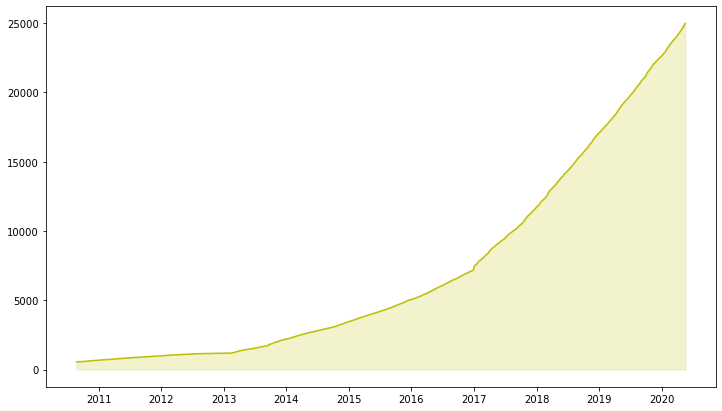

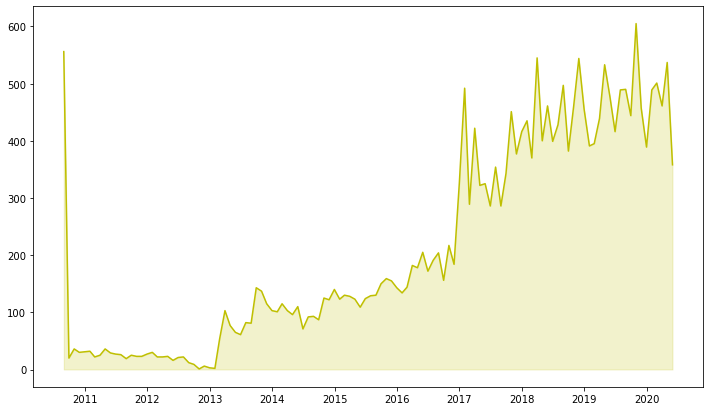

In [233]:
pandas_visualizer.stargazer_history()

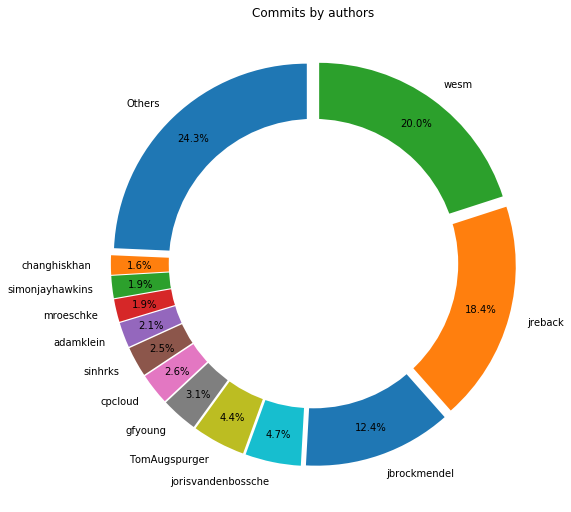

In [7]:
pandas_visualizer.commits_by_author()

In [8]:
pandas_visualizer.lines_over_time()

TypeError: strptime() argument 1 must be str, not datetime.date